In [1]:
# install sompy
# !conda install git
# !pip install -U git+https://github.com/sevamoo/SOMPY.git
# !pip install scikit-image
# IF THIS IT TAKING TOO LONG, TRY TO INSTALL IT FROM THE ANACONDA PROMPT

In [2]:
from IPython.display import YouTubeVideo

from os.path import join
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

In [3]:
from matplotlib import __version__ as mplver


In [4]:
print("matplotlib version is:" , mplver)

matplotlib version is: 3.7.2


## Import preprocessed data

In [5]:
df = pd.read_csv("dataset.csv")

In [6]:
df.set_index("ID", inplace=True)

In [7]:
df.head()

,Age,UseByTime,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities,OtherActivities,Dropout,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Freq_Classes_Contract,Visits_ActivePeriod,Gender_Female
ID,,,,,,,,,,,,,,,,,,
10000,3.083333,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,-0.490868,1.15,1.866571,0.763419,9.579365,-0.201465,1
10001,0.500000,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.285388,-0.20,0.104392,-0.204771,0.198413,-0.501832,1
10002,0.000000,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,-0.554795,0.50,0.000000,1.208748,0.000000,0.619048,0
10003,-1.166667,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,-0.257991,0.35,0.239981,0.463221,0.992063,-0.300366,0
10004,1.000000,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1.152968,-0.50,0.000000,-0.255467,0.000000,-0.600733,0


In [8]:
df.columns

Index(['Age', 'UseByTime', 'AthleticsActivities', 'WaterActivities',
       'FitnessActivities', 'TeamActivities', 'RacketActivities',
       'CombatActivities', 'SpecialActivities', 'OtherActivities', 'Dropout',
       'Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Freq_Classes_Contract', 'Visits_ActivePeriod',
       'Gender_Female'],
      dtype='object')

In [9]:
metric_features = ['Age','Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Freq_Classes_Contract', 'Visits_ActivePeriod']

non_metric_features = df.columns.drop(metric_features).to_list()

In [10]:
metric_features.remove('Freq_Classes_Contract')

## Self-organizing maps
What is a SOM? How does it work? What is it used for?

The SOM objective is to adjust the units to the data in the input space, so that the
network is (as best as possible) representative of the training dataset.

### How is it computed?
### Important concepts:
- Units and observations
- BMU
- Neighborhood function
- Input and Output space

**Video:**

(May be a good idea to mute the video before playing)

https://www.youtube.com/watch?v=k7DK5fnJH94


### Characteristics:
- Grid shape needs to be set a priori
- Results depend on the initialization (even tough it can be quite robust to it)
- Fitting a SOM can be computationally expensive
- Capable of finding the global optimum (theoretically - if the LR -> 0)
- Visualization tool for high-dimensional data

### Additional analyses/tutorials
- [Air Flights](https://github.com/sevamoo/SOMPY/blob/master/sompy/examples/AirFlights_hexagonal_grid.ipynb)
- [Visualizations on toy datasets](https://gist.github.com/sevamoo/035c56e7428318dd3065013625f12a11)

### How to apply Self-Organizing Maps?

The training of a SOM is **more effective** if it is done in two phases: the unfolding phase, and the fine-tuning phase. 

In the **unfolding phase** the objective is to **spread the units** in the region of the input space where the data patterns are located. In this phase the neighbourhood function should have a large initial radius so that all units have high mobility and the map can quickly cover the input space.

The **fine tuning phase**, as the name implies, is the process of small adjustments in order to **reduce the quantization error**, and centre the units in the areas where the density of patterns is highest. Usually, in this phase the learning rate and the neighbourhood radius are smaller than the ones used in the unfolding phase. As these two parameters are smaller, the map will need more time to adjust its weights and that is why the number of iterations or epochs is normally higher.

**Exercise**
- Train a SOM with a 10x10 grid, random initialization, gaussian neighborhood function and hexagonal topology/lattice
- Set an unfolding phase and a fine tuning phase of 100 iterations

In [11]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

sm = sompy.SOMFactory().build(
    df[metric_features].values, 
    mapsize=[10, 10],  # NEEDS TO BE A LIST
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=4, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.043000, quantization error: 3.875335

 epoch: 2 ---> elapsed time:  0.026000, quantization error: 2.147949

 epoch: 3 ---> elapsed time:  0.043000, quantization error: 2.088251

 epoch: 4 ---> elapsed time:  0.023000, quantization error: 2.061228

 epoch: 5 ---> elapsed time:  0.015000, quantization error: 2.035751

 epoch: 6 ---> elapsed time:  0.016000, quantization error: 2.019071

 epoch: 7 ---> elapsed time:  0.015000, quantization error: 2.008160

 epoch: 8 ---> elapsed time:  0.015000, quantization error: 2.000739

 epoch: 9 ---> elapsed time:  0.015000, quantization error: 1.994886

 epoch: 10 ---> elapsed time:  0.016000, quantization error: 1.988675

 epoch: 11 ---> elapsed time:  0.014000, quantization error: 1.983548

 epoch: 12 ---> elapsed time:  0.014000, quantization error: 1.979862

 epoch: 13 ---> 

## Visualizing data with SOMs

Improving the visualizations produced by SOMPY is not a straightforward process.

If you run into any issues with the SOMPY library that you are not able to fix even after searching on Google, you can instead use the [MiniSOM library](https://github.com/JustGlowing/minisom). It does not come with its own visualizations, but there are examples in the minisom version of the notebooks.


### Component planes
What do they represent? What kinds of information do they contain?

Analyse these plots from the following perspectives:
- Feature importance
- Feature correlation (both globally and locally)
- Data distribution
- Outlier detection

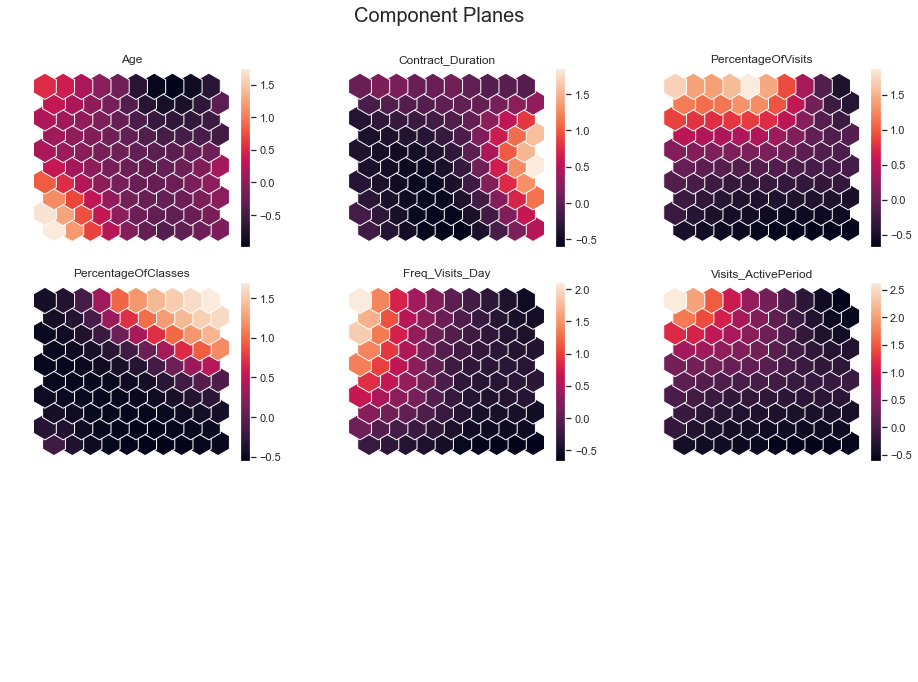

In [12]:
## You may need to play around with this setting if the hexagon tiling looks "weird"; 
## Improving the visualizations produced by SOMPY is not a straightforward process

plt.rcParams['figure.dpi'] = 72


# Visualizing the Component planes (feature values)
sns.set()
view2D = View2D(12, 12, "", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

## U-matrix
Encode each neuron in the output space with the **average distance** to its neighbors in the input space.

Analyse these plots from the following perspectives:
- Clusters of units
- Potential outliers (units which are very distant from its neighbors and have low frequency)

/Users/sofiapereira/anaconda3/envs/DM2324/lib/python3.11/site-packages/sompy/visualization/umatrix.py:60: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X, Y, s=2, alpha=1., c='Gray',


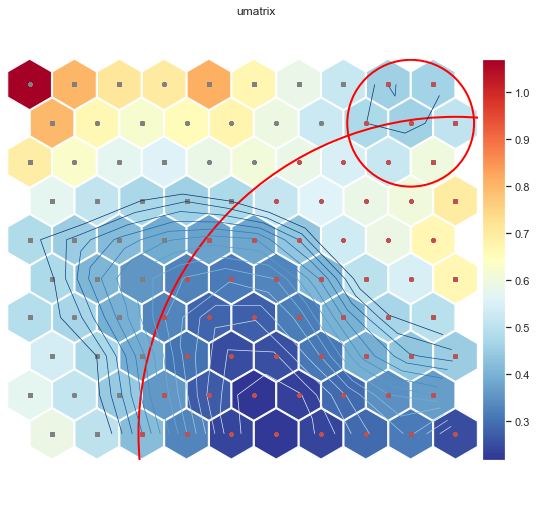

array([[1.07140512, 0.80268088, 0.70978799, 0.6998657 , 0.81173523,
        0.66859294, 0.58166987, 0.51958799, 0.4551212 , 0.46157274],
       [0.79671564, 0.66317184, 0.62336548, 0.65675521, 0.67229878,
        0.59351255, 0.52482874, 0.47480791, 0.45883215, 0.50744037],
       [0.69167425, 0.63085891, 0.57450975, 0.55562004, 0.58474936,
        0.60665064, 0.58300134, 0.54797499, 0.52058095, 0.59905952],
       [0.57179445, 0.50999686, 0.4737213 , 0.45734165, 0.47563206,
        0.51495202, 0.56097349, 0.58534   , 0.60448249, 0.69636386],
       [0.48227341, 0.45065607, 0.41538374, 0.3858526 , 0.37271516,
        0.37940652, 0.43798532, 0.5322571 , 0.5887027 , 0.66734897],
       [0.47742472, 0.40649524, 0.35313244, 0.32586443, 0.31235727,
        0.32890717, 0.4053383 , 0.50091775, 0.5479911 , 0.66527093],
       [0.48899036, 0.46804109, 0.39594982, 0.32959329, 0.28179606,
        0.27475737, 0.31474643, 0.40127687, 0.47080946, 0.49577409],
       [0.54106265, 0.47433526, 0.3896401

In [13]:
# Here you have U-matrix
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=2,
    row_normalized=False,
    show_data=True, 
    contour=True, # Visualize isomorphic curves
    blob=True
)

np.flip(UMAT[1], axis=1) # U-matrix values - they match with the plot colors

### Hit-map
Show the **frequency** of each Unit in the output map

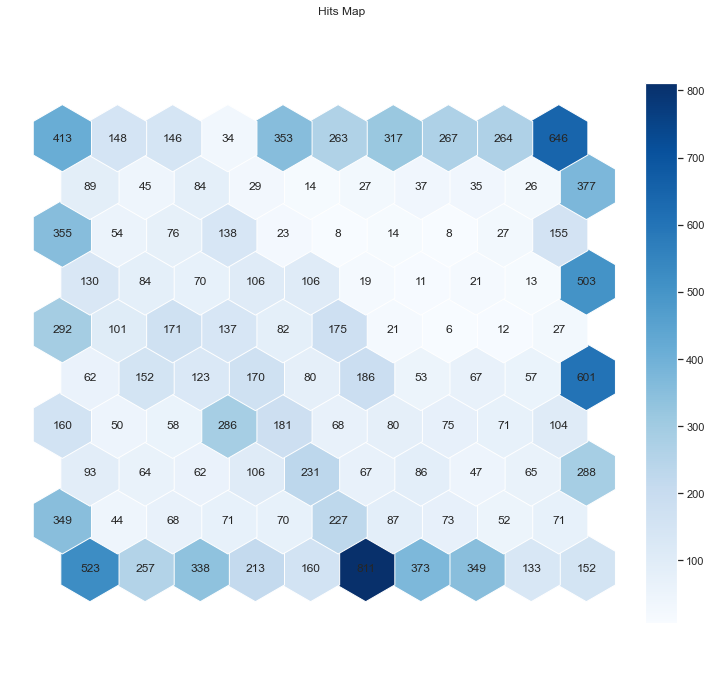

In [14]:
vhts  = BmuHitsView(12,12,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
plt.show()

## Clustering with SOMs: K-means SOM vs Emergent SOM
- In **k-means SOM**, the *number of units should be equal to the expected number of clusters*, and thus each cluster should be represented by a single unit. 
- In **emergent SOM**, a very *large number of units is used*. These very large SOM allow for very clear U-Matrices and are useful for detecting quite clearly the underlying structure of the data. This technique can be **used together with other clustering algorithms**.

**Exercise**
- Train a SOM with a 50x50 grid, random initialization, gaussian neighborhood function and hexagonal topology/lattice
- Set an unfolding phase and a fine tuning phase of 100 iterations

In [15]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm = sompy.SOMFactory().build(
    df[metric_features].values, 
    mapsize=[50, 50],  # NEEDS TO BE A LIST
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)

## This will take a few minutes!
# sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)
sm.train(n_job=-1, verbose='info', train_rough_len=50, train_finetune_len=50)


 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 50

 epoch: 1 ---> elapsed time:  7.701000, quantization error: 1.897285

 epoch: 2 ---> elapsed time:  6.860000, quantization error: 2.154029

 epoch: 3 ---> elapsed time:  6.735000, quantization error: 2.135597

 epoch: 4 ---> elapsed time:  6.814000, quantization error: 2.129141

 epoch: 5 ---> elapsed time:  7.959000, quantization error: 2.124445

 epoch: 6 ---> elapsed time:  7.293000, quantization error: 2.121970

 epoch: 7 ---> elapsed time:  7.227000, quantization error: 2.119714

 epoch: 8 ---> elapsed time:  7.370000, quantization error: 2.117338

 epoch: 9 ---> elapsed time:  6.748000, quantization error: 2.114679

 epoch: 10 ---> elapsed time:  7.228000, quantization error: 2.111622

 epoch: 11 ---> elapsed time:  7.423000, quantization error: 2.108102

 epoch: 12 ---> elapsed time:  7.130000, quantization error: 2.104811

 epoch: 13 ---> 

In [ ]:
# Coordinates of the units in the input space
sm.codebook.matrix

array([[ 0.700221, -0.474186, -0.513141,  2.11194 , -0.620162, -0.634623],
       [ 0.429765, -0.520841, -0.544406,  1.943974, -0.636986, -0.661132],
       [ 0.127882, -0.561284, -0.613875,  1.878301, -0.668371, -0.676154],
       ...,
       [ 2.657548, -0.216243, -0.599932,  0.626108, -0.430783, -0.600921],
       [ 2.450439, -0.087056, -0.576622,  1.218043, -0.41245 , -0.621372],
       [ 2.370479, -0.056171, -0.540983,  1.576448, -0.378176, -0.612778]])

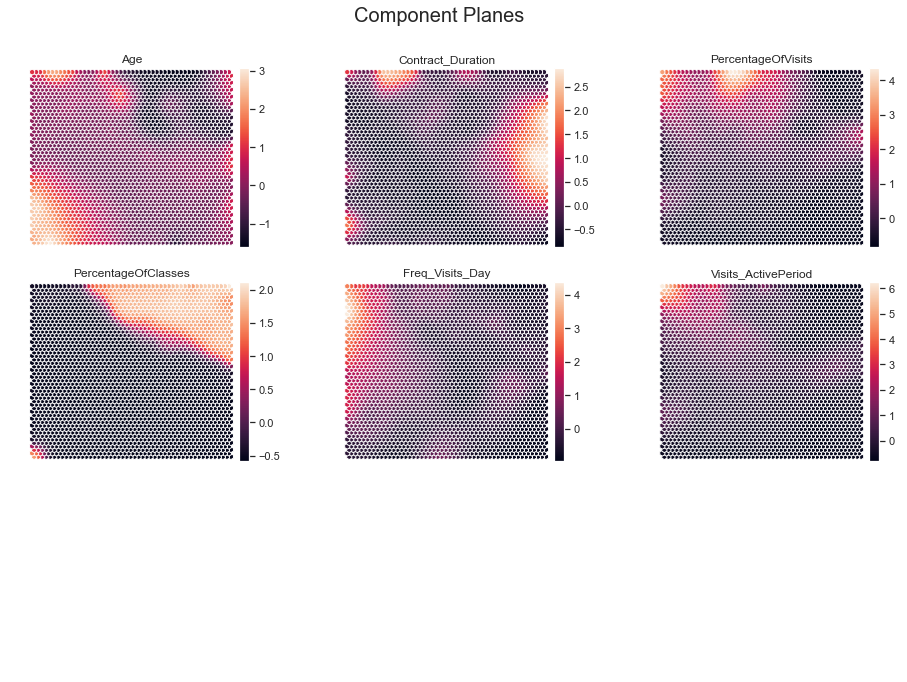

In [ ]:
# Component planes on the 50x50 grid
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

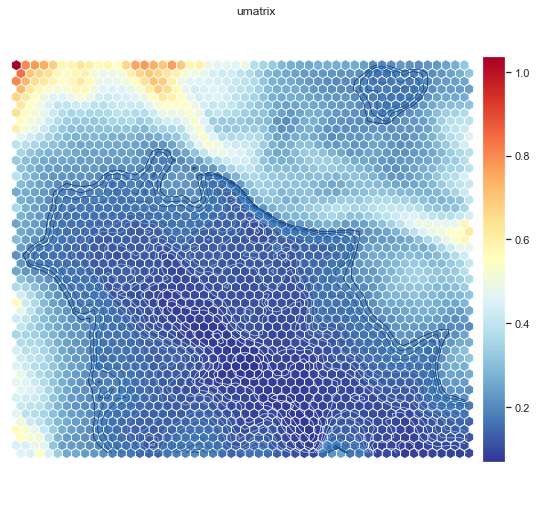

In [ ]:
# U-matrix of the 50x50 grid
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=2, 
    row_normalized=False, 
    show_data=False, 
    contour=True # Visualize isomorphic curves
)

Now we can have a better idea of how the input space look like in terms of distances.

### K-Means on top of SOM units
- Define number of clusters to retain

In [ ]:
# Exercise:
# Do the Inertia plot here (check last class' notebook)

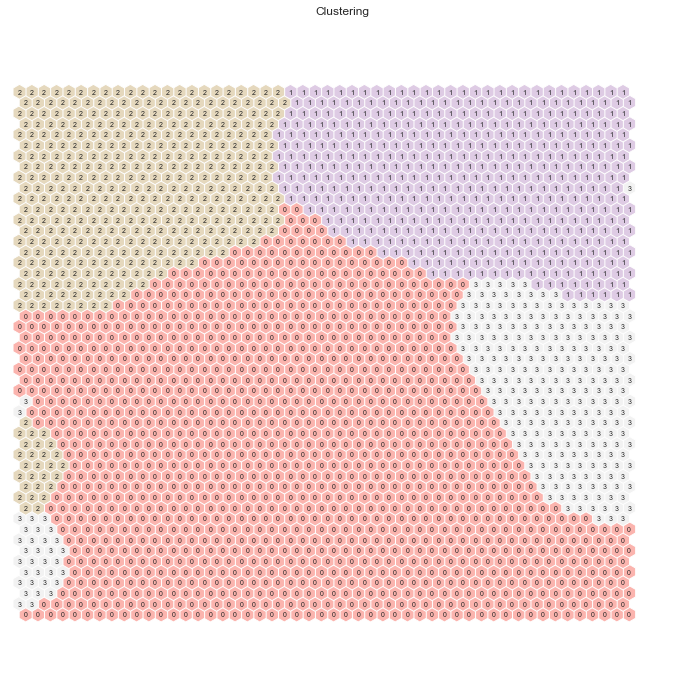

In [ ]:
# Perform K-Means clustering on top of the 2500 units (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

### Hierarchical Clustering on top of SOM units
- Define best linkage method
- Define number of clusters to retain

In [ ]:
# Exercise:
# Do the R² plot here and the Dendrogram (check last class' notebook)

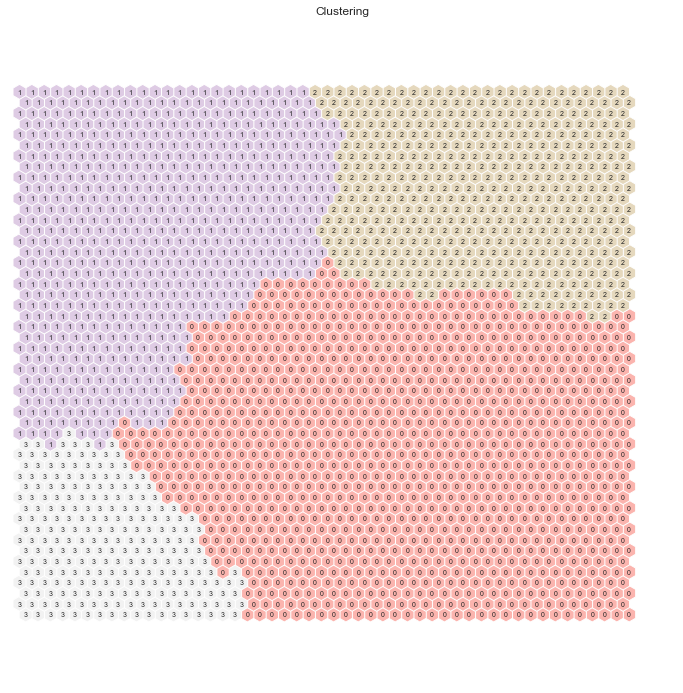

In [ ]:
# Perform Hierarchical clustering on top of the 2500 units (sm.get_node_vectors() output)
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hierclust.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

### Final SOM Clustering solution

In [ ]:
# Check the nodes and and respective clusters
nodes = sm.codebook.matrix

df_nodes = pd.DataFrame(nodes, columns=metric_features)
df_nodes['label'] = nodeclus_labels
df_nodes

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,label
0,0.700221,-0.474186,-0.513141,2.111940,-0.620162,-0.634623,2
1,0.429765,-0.520841,-0.544406,1.943974,-0.636986,-0.661132,2
2,0.127882,-0.561284,-0.613875,1.878301,-0.668371,-0.676154,2
3,-0.147147,-0.583776,-0.663600,1.869800,-0.701928,-0.695927,2
4,-0.408601,-0.556133,-0.672154,1.870983,-0.757444,-0.706714,2
...,...,...,...,...,...,...,...
2495,3.063281,-0.454461,-0.665504,-0.421152,-0.406651,-0.560404,3
2496,2.930224,-0.361394,-0.647206,-0.035587,-0.416302,-0.581603,3
2497,2.657548,-0.216243,-0.599932,0.626108,-0.430783,-0.600921,3
2498,2.450439,-0.087056,-0.576622,1.218043,-0.412450,-0.621372,3


In [ ]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(df[metric_features])[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((df, np.expand_dims(bmus_map,1)), axis=1),
    index=df.index, columns=np.append(df.columns,"BMU")
)
df_bmus

,Age,UseByTime,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities,OtherActivities,Dropout,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Freq_Classes_Contract,Visits_ActivePeriod,Gender_Female,BMU
ID,,,,,,,,,,,,,,,,,,,
10000,3.083333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.490868,1.15,1.866571,0.763419,9.579365,-0.201465,1.0,327.0
10001,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.285388,-0.20,0.104392,-0.204771,0.198413,-0.501832,1.0,2050.0
10002,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.554795,0.50,0.000000,1.208748,0.000000,0.619048,0.0,891.0
10003,-1.166667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.257991,0.35,0.239981,0.463221,0.992063,-0.300366,0.0,771.0
10004,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.152968,-0.50,0.000000,-0.255467,0.000000,-0.600733,0.0,1850.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24937,-0.750000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.997717,0.65,2.056875,0.190855,6.634921,1.000000,0.0,903.0
24938,1.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.027397,-0.25,0.000000,1.391650,0.000000,0.007326,0.0,1598.0
24939,-0.250000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.554795,0.85,0.000000,1.208748,0.000000,1.025641,0.0,791.0


In [ ]:
# Get cluster labels for each observation
df_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)
df_final

,Age,UseByTime,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities,OtherActivities,Dropout,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Freq_Classes_Contract,Visits_ActivePeriod,Gender_Female,BMU,label
ID,,,,,,,,,,,,,,,,,,,,
10000,3.083333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.490868,1.15,1.866571,0.763419,9.579365,-0.201465,1.0,327.0,1
10001,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.285388,-0.20,0.104392,-0.204771,0.198413,-0.501832,1.0,2050.0,0
10002,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.554795,0.50,0.000000,1.208748,0.000000,0.619048,0.0,891.0,1
10003,-1.166667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.257991,0.35,0.239981,0.463221,0.992063,-0.300366,0.0,771.0,2
10004,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.152968,-0.50,0.000000,-0.255467,0.000000,-0.600733,0.0,1850.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24937,-0.750000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.997717,0.65,2.056875,0.190855,6.634921,1.000000,0.0,903.0,2
24938,1.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.027397,-0.25,0.000000,1.391650,0.000000,0.007326,0.0,1598.0,1
24939,-0.250000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.554795,0.85,0.000000,1.208748,0.000000,1.025641,0.0,791.0,1


In [ ]:
# Characterizing the final clusters
df_final.drop(columns='BMU').groupby('label').mean()

,Age,UseByTime,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities,OtherActivities,Dropout,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Freq_Classes_Contract,Visits_ActivePeriod,Gender_Female
label,,,,,,,,,,,,,,,,,,
0,0.068027,0.066117,0.006431,0.136857,0.733521,0.017886,0.002814,0.191519,0.010651,0.000201,0.908762,0.362379,-0.159305,0.028765,-0.138885,0.077170,-0.123995,0.617363
1,0.367620,0.047529,0.006148,0.212107,0.735635,0.018208,0.026247,0.050603,0.036888,0.002128,0.785528,0.126205,1.021223,0.323644,1.128359,1.460790,1.247430,0.577205
2,-0.798439,0.018257,0.007067,0.652532,0.110130,0.176678,0.061249,0.070966,0.011484,0.004417,0.713486,0.607173,0.244994,1.809708,-0.170024,3.837416,-0.141801,0.570377
3,2.127225,0.048803,0.011971,0.244015,0.662063,0.015654,0.005985,0.087017,0.061234,0.001381,0.849908,0.139650,-0.084968,0.239275,0.149040,0.560010,-0.032969,0.637201


## Analysing the appropriateness of our solution
### R²

In [ ]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_final[metric_features])  # get total sum of squares
ssw_labels = df_final[metric_features + ["label"]].groupby(by='label').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.3708904003601799

In [ ]:
df_final[["label"]].groupby(["label"]).value_counts()

label
0    4976
1    4229
2    3396
3    2172
Name: count, dtype: int64

### Quantization error:
The quantization error is given by the average distance between a unit and the data points mapped to it i.e. all the input data points that share it as BMU.

$$q_e = \frac{\sum_{i=0}^{N_e}||x_i - w_e||}{N_e}$$

$$Q = \frac{\sum_{e=0}^Eq_e}{E}$$
, where:

$Q$ is the overall quantization error of SOM,

$q_e$ is the quantization error for unit $e$,

$x_i$ is a data point/ observation,

$w_e$ is the unit $e$ representation in the input space,

$N_e$ is number of data points mapped to unit $e$,

$E$ is the number of units in the SOM grid

In [ ]:
cluster_means = df_final.groupby('label').mean()[metric_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

label,0,1,2,3
Age,0.07,0.37,-0.80,2.13
Contract_Duration,0.36,0.13,0.61,0.14
PercentageOfVisits,-0.16,1.02,0.24,-0.08
PercentageOfClasses,0.03,0.32,1.81,0.24
Freq_Visits_Day,-0.14,1.13,-0.17,0.15
Visits_ActivePeriod,-0.12,1.25,-0.14,-0.03


In [ ]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
       
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


/var/folders/x6/c7bgz3zn0hg_kdmljrfw7k_m0000gn/T/ipykernel_25089/2606922159.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(cluster_labels)


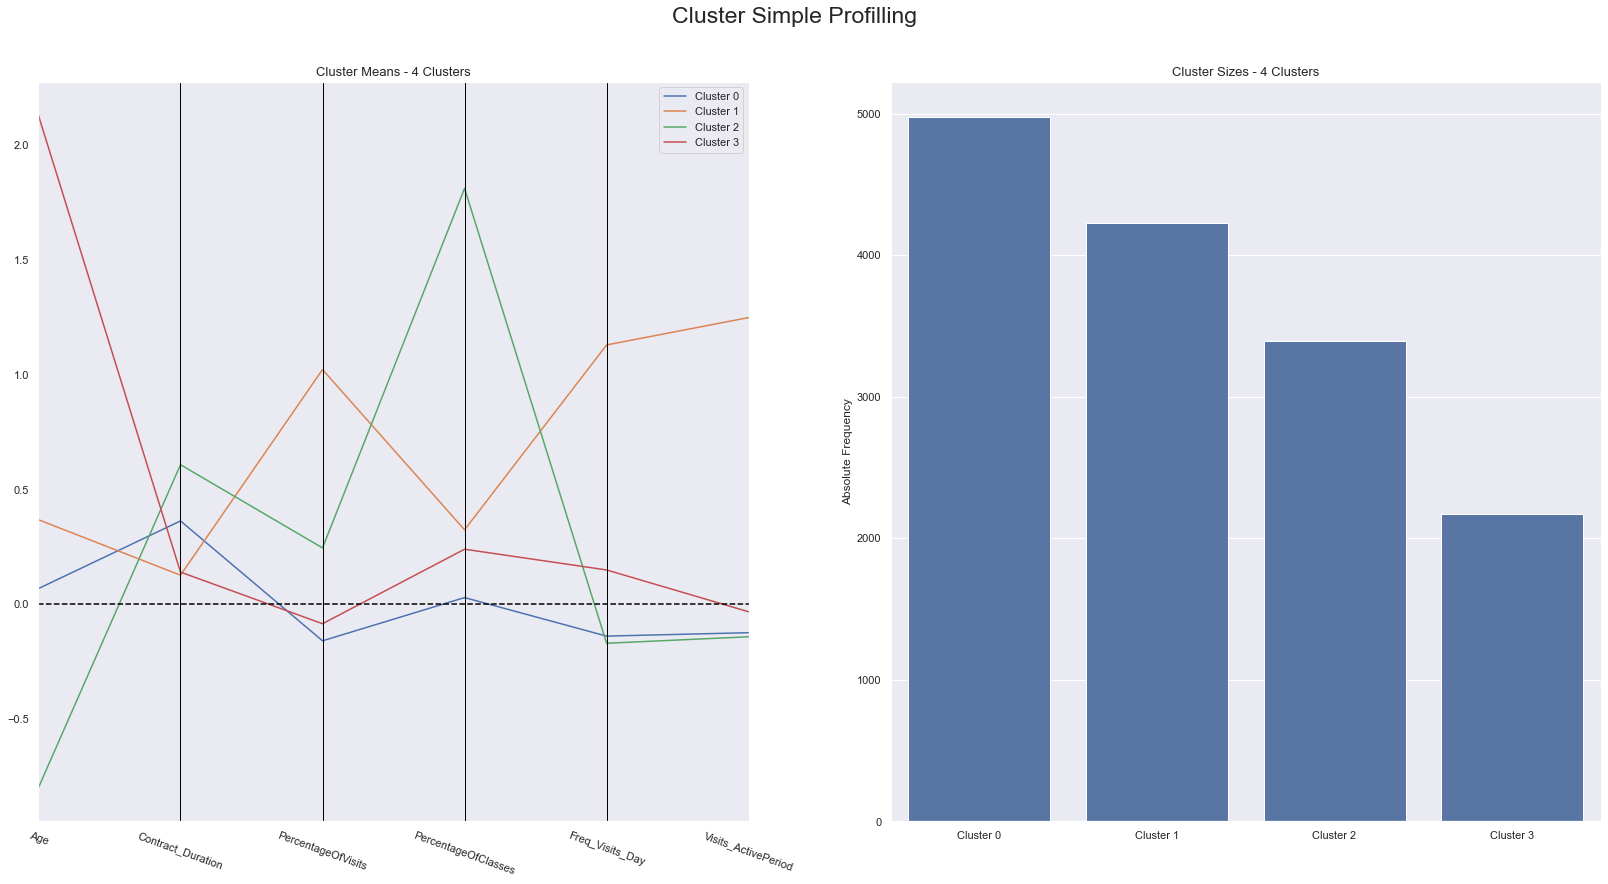

In [ ]:
cluster_profiles(
    df = df_final[metric_features + ["label"]], 
    label_columns = ["label"], 
    figsize = (28, 13), 
    compar_titles = [""]
)

In [ ]:
df_educ = df_final[["label"] + non_metric_features].groupby(["label"]).sum()
df_final[["label"]].groupby(["label"]).value_counts()

label
0    4976
1    4229
2    3396
3    2172
Name: count, dtype: int64

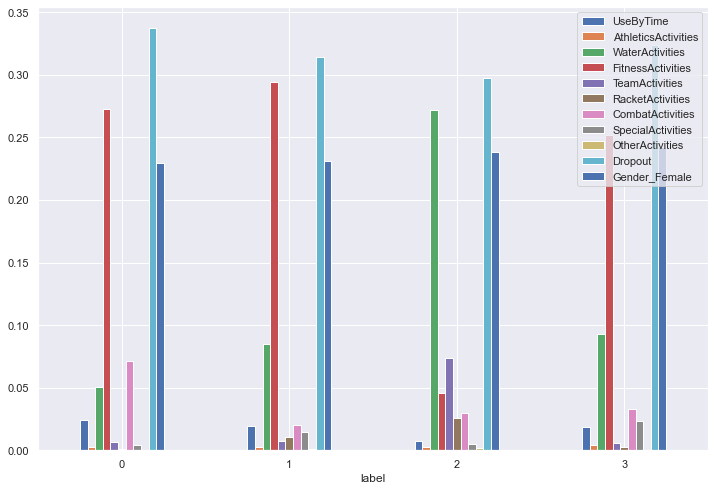

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

df_educ_pct = df_educ.apply(lambda col: col/df_educ.sum(axis=1))
df_educ_pct.plot(kind='bar', stacked=False, ax=ax)
plt.xticks(rotation=0)

plt.show()

In [ ]:
from sklearn.manifold import TSNE

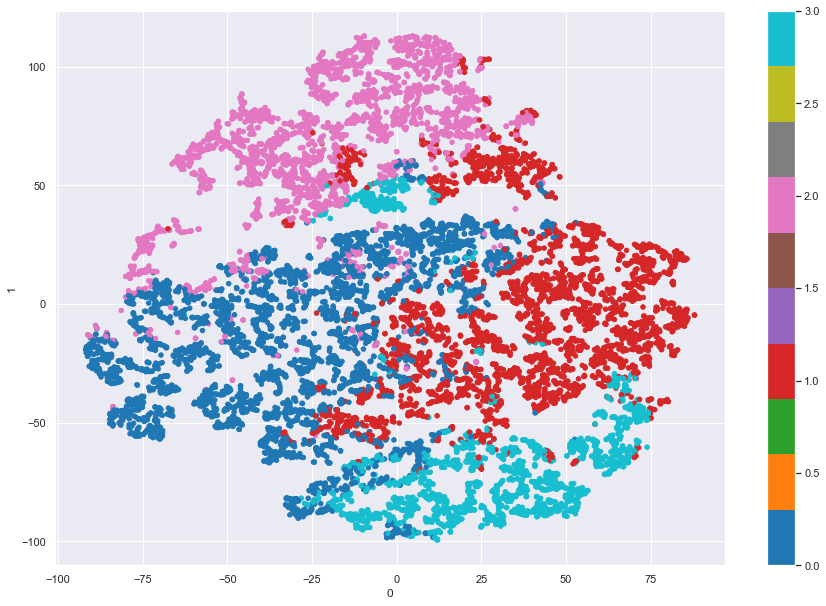

In [ ]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(df_final[metric_features])
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_final["label"], colormap='tab10', figsize=(15,10))
plt.show()

In [ ]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [ ]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df_final[metric_features + ['label']], 'label').drop('label')

Age                    0.567951
Contract_Duration      0.039552
PercentageOfVisits     0.300591
PercentageOfClasses    0.523238
Freq_Visits_Day        0.363926
Visits_ActivePeriod    0.322084
dtype: float64

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz

In [ ]:
# Preparing the data
X = df_final.drop(columns=['label'])
y = df_final.label

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 90.02% of the customers correctly
